## Data Dreamers Semester 1 Project



Created by: Habib Khadri, Nick Kirbabas, Seerat Mutneja, Sidhya Raman, Douglas Riggs, Andrew Yang

# Introduction

This is the semester 1 Capstone project for team Data Dreamers. We'll give an overview of the business problem, a walkthrough of the data, explain how we prepared the data, show our analysis of the data, and show the statistical analysis we performed.

# Business Understanding

Our client and business stakeholder, Computing Vision, an established company making a new movie studio, is trying to find ways to gain a competitive advantage within a filmmaking industry.

In order to do so, they need to understand what types of films are currently doing the best at the box office to optimize their content and successfully create a new movie studio. With this information, they will be able to optimize the characteristics of their movie and have the best chance possible at creating a successful film.

# Data Exploration & Cleaning

First, we'll import all packages we could potentially use, as well as creating our databse connection.

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
%matplotlib inline
# You'll need to unzip the db locally.
conn = sqlite3.connect('zippedData/im.db')

Now, let's take a look at the datasets that we'll be using. We had a variety of datasets from websites which each had different data about movies. We took a look at the different datasets and chose 3 which covered all the characteristics which we wanted to cover.

First, let's look at tn movie budgets (https://www.the-numbers.com/movie/budgets). From this database, we'll be heavily using the production budget and worldwide gross as our metric on how successful a movie is. We'll also use the release data to see if a movies release time affects its performance.

In [2]:
tn_df = pd.read_csv("zippedData/tn.movie_budgets.csv.gz").drop("id", axis = 1)

In [3]:
tn_df.head(3)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"


In [4]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 226.0+ KB


No null values, that's great! Everything is a string, including the date, production budget and worldwide gross, so we'll have to clean those up later. Now, lets look at the BOM dataset (https://www.boxofficemojo.com/).

In [5]:
bom_df = pd.read_csv("zippedData/bom.movie_gross.csv.gz")

In [6]:
bom_df.head(3)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010


In [7]:
bom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB


Looks like there are some null values in the gross columns, but we won't need to use those. There are also a few values missing from studio, probably best to drop those, since it is such a small amount, and we want to have studio present, since our movie will be made by a studio. Finally let's look at the IMDB dataset (https://www.imdb.com/).

In [8]:
# Grab movie basics info along with average ratings for each from imdb dataset
imdb_df = pd.read_sql('''
SELECT *
FROM movie_basics
LEFT JOIN movie_ratings 
    USING("movie_id")
''',conn)

In [9]:
imdb_df.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517.0


In [10]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
 6   averagerating    73856 non-null   float64
 7   numvotes         73856 non-null   float64
dtypes: float64(3), int64(1), object(4)
memory usage: 8.9+ MB


Looks like there are some values missing from the averagerating and numvotes columns - these won't be an issue, since we didn't end up actually using these columns. More concerning are the missing values from genres and runtime-minutes. For genres, we can't really come up with an alternative, and the amount isn't too large, just a few thousand, so we can drop those rows. For runtime, it is more difficult to drop the rows, since it is over 1/4 of the dataset - however, we can pretty easily come up with a replacement, by taking the mean of the existing runtime values and plugging it in for the missing ones. It isn't ideal, but if we look at the distribution -

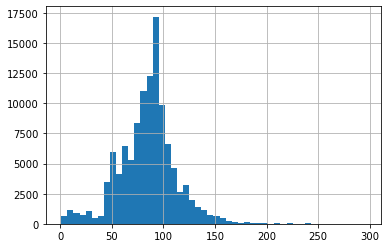

In [11]:
imdb_df[(imdb_df.runtime_minutes < 300)].runtime_minutes.hist(bins=50);

\- it is pretty normal, so mean should be a suitable substitute.

Let's clean up our datasets! First, in tn movie budgets, we'll convert the monetary columns and get dates from the release_date column.

In [12]:
# load tn dataset and clean up columns regarding budget and gross profit
tn_df["production_budget"].replace(["\$",","], "", regex = True, inplace = True)
tn_df["domestic_gross"].replace(["\$",","], "", regex = True, inplace = True)
tn_df["worldwide_gross"].replace(["\$",","], "", regex = True, inplace = True)

# convert budget and profit columns to numeric
cols = ["production_budget","domestic_gross","worldwide_gross"]
tn_df[cols] = tn_df[cols].apply(pd.to_numeric)

# created new columns to grab date information (day, week of year, month, etc.)
tn_df["datetime"] = [datetime.strptime(d, "%b %d, %Y") for d in tn_df["release_date"]]
tn_df["release_weeknum"] = [d.isocalendar()[1] for d in tn_df["datetime"]]
tn_df["release_weekday"] = [d.weekday() for d in tn_df["datetime"]]
tn_df["release_month"] = [d.month for d in tn_df["datetime"]]
tn_df["release_year"] = [d.year for d in tn_df["datetime"]]

# calc movie seasonal info (came out on a weekend, calander season)
tn_df["weekend"]  = np.where((tn_df["release_weekday"]== 5) |
                                  (tn_df["release_weekday"]== 6),
                                    1, 0)   
tn_df.head(1)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend
0,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009-12-18,51,4,12,2009,0


Next, in the BOM dataset we'll drop rows without a studio, and clean up the other columns

In [13]:
# cleaned up dataset by gathering gross profit values
bom_df["foreign_gross"].replace(",","", regex = True, inplace = True)
bom_df["foreign_gross"] = pd.to_numeric(bom_df["foreign_gross"])
bom_df["foreign_gross"].fillna(bom_df["foreign_gross"].median(), inplace = True)
bom_df["domestic_gross"].fillna(bom_df["domestic_gross"].median(), inplace = True)
bom_df.dropna(subset = ["studio"], inplace = True)
bom_df.head(1)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010


Finally, from the IMDB dataset, we'll drop rows without a genre, and fill in a few columns missing values with mean/median. We'll also get rid of excessively long movies which are extreme outliers.

In [14]:
# Data cleaning to get genre count and runtime minutes
imdb_df.dropna(subset = ["genres"], inplace = True)
imdb_df["runtime_minutes"] = imdb_df["runtime_minutes"]\
                                .fillna(imdb_df["runtime_minutes"].mean())
imdb_df["averagerating"] = imdb_df["averagerating"]\
                            .fillna(imdb_df["averagerating"].mean())
imdb_df["numvotes"] = imdb_df["numvotes"]\
                        .fillna(imdb_df["numvotes"].median())
imdb_df["genres_list"] = [gs.split(",") for gs in imdb_df["genres"]]
imdb_df["genres_count"] = [len(gs) for gs in imdb_df["genres_list"]]
imdb_df = imdb_df[imdb_df["runtime_minutes"] <= 300]
imdb_df.head(1)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77.0,"[Action, Crime, Drama]",3


Looks like we're ready to combine our datasets!

## Choose Metric, Join IMDB, BOM and TN Movie Budgets

Now, we'll join the 3 datasets that we loaded. We'll use both movie title and release year to make sure that our resulting data is correct. We'll use inner joins, since we've already dealt with null values that we are able to handle.

We'll also create the column for the metric that we'll be using, adjusted worldwide gross. This is the worldwide gross - production budget. We would like to factor in the full cost of the movie, including advertising, and revenue splits with theaters, as well as all of the revenue generated by the movie, including merchandising and TV/streaming rights - however, those numbers are not present in any of the datasets, so production costs and box office gross are the best that we can do.

We've chosen this metric specifically because we feel that it is the best indicator of a 'successful' movie. Alternative metrics we investigated were: 
- Ratings. We didn't pick ratings, since they didn't seem to be very related any monetary metric, which we felt was important for creating a successful movie.
- Gross revenue. We chose revenue adjusted by production budget, since there was a strong correlation between budget and revenue, and we wanted to correct for that a bit - gross revenue greatly oversells movies which had a high production budget and barely broke even/lost money.
- Some ratio between revenue and budget - while this is a good metric, we felt that it didn't necessarily indicate the most 'successful' film. This category is dominated by cheap films, which while extremely profitable, didn't have the same 'successful' feel as movies with high budgets and higher box office results. We want want to provide our client with a box office hit, not with a sleeper hit on a shoestring budget.
- Number of votes. We wanted to use some type of engagement metric to show how much 'buzz' each movie generated, but the best metric we had was imdb's number of votes for their reviews. While it did indicate movies which were 'popular' and is a potential indicator of success, we didn't want to rely on it as a sole indicator of success.

In [15]:
# merging datasets imdb (cleaned) and bom (cleaned) with inner join
# on movie titles and year of movie release
imdb_df_c = imdb_df.merge(bom_df, how = "inner", 
                          left_on = ["primary_title", "start_year"], 
                          right_on = ["title","year"])
imdb_df_c.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,title,studio,domestic_gross,foreign_gross,year
0,tt0315642,Wazir,Wazir,2016,103.0,"Action,Crime,Drama",7.1,15378.0,"[Action, Crime, Drama]",3,Wazir,Relbig.,1100000.0,18700000.0,2016
1,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",6.1,37886.0,"[Adventure, Drama, Romance]",3,On the Road,IFC,744000.0,8000000.0,2012


In [16]:
# merging datasets imdb_c (cleaned) and tn (cleaned) with inner join
# on movie titles and year of movie release
imdb_df_c2 = imdb_df_c.merge(tn_df, how = "inner", 
                             left_on = ["primary_title", "start_year"], 
                             right_on = ["movie","release_year"])

# create release season of movies
seasons = []
for m in imdb_df_c2["release_month"]:
    if(m in [12,1,2]): 
        seasons.append("winter")
    elif(m in [3,4,5]): 
        seasons.append("spring")
    elif(m in [6,7,8]): 
        seasons.append("summer")
    else: 
        seasons.append("fall")

imdb_df_c2["release_season"] = seasons 

# create worldwide profit, adjusted for production budge
imdb_df_c2["adjusted_worldwide"] = imdb_df_c2["worldwide_gross"] - imdb_df_c2["production_budget"]

# it's beautiful
imdb_df_c2.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,...,domestic_gross_y,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend,release_season,adjusted_worldwide
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300.0,"[Adventure, Comedy, Drama]",3,...,58236838,187861183,2013-12-25,52,2,12,2013,0,winter,96861183
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116.0,"[Action, Crime, Drama]",3,...,26017685,62108587,2014-09-19,38,4,9,2014,0,fall,34108587


In [17]:
imdb_df_c2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1050
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_id            1051 non-null   object        
 1   primary_title       1051 non-null   object        
 2   original_title      1051 non-null   object        
 3   start_year          1051 non-null   int64         
 4   runtime_minutes     1051 non-null   float64       
 5   genres              1051 non-null   object        
 6   averagerating       1051 non-null   float64       
 7   numvotes            1051 non-null   float64       
 8   genres_list         1051 non-null   object        
 9   genres_count        1051 non-null   int64         
 10  title               1051 non-null   object        
 11  studio              1051 non-null   object        
 12  domestic_gross_x    1051 non-null   float64       
 13  foreign_gross       1051 non-null   float64     

All our columns are here, with no null values! Unfortunately, our dataset has been reduced to 1051 movies due to the datasets not lining up perfectly, but this is still a large enough set of movies to work with.

With our full dataset ready, we can start to do our analysis!

# Metric 1: Genre

The first thing we want to check is which genre is the most profitable. To do this, we'll have to group the movies by genre to see how the average movie in each genre performs. First, let's take a look at our table:

In [18]:
imdb_df_c2.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres_list,genres_count,...,domestic_gross_y,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend,release_season,adjusted_worldwide
0,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300.0,"[Adventure, Comedy, Drama]",3,...,58236838,187861183,2013-12-25,52,2,12,2013,0,winter,96861183
1,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116.0,"[Action, Crime, Drama]",3,...,26017685,62108587,2014-09-19,38,4,9,2014,0,fall,34108587


Seems like most movies have more then 1 genre. We'll have to split out the genres to get information on how well each separated genre performs. This is not ideal, as there may be heavy correlation between genres that are commonly used together, but it's the best we can do.

In [19]:
# Splitting the genre column into separate rows for each listed genre
imdb_tn_split_df = imdb_df_c2.copy()
imdb_tn_split_df = pd.DataFrame({'genres':imdb_tn_split_df.genres.str.split(','),\
                                 'movie':imdb_tn_split_df.primary_title}, )\
                                .explode('genres')

In [20]:
# Check that the result looks as expected
imdb_tn_split_df.head(2)

,genres,movie
0,Adventure,The Secret Life of Walter Mitty
0,Comedy,The Secret Life of Walter Mitty


In [21]:
# Join back with the original dataframe to get the rest of the columns, 
# since we only have genre and movie name.
imdb_tn_split_df = imdb_tn_split_df.set_index('movie');
imdb_tn_df = imdb_df_c2.copy().set_index('primary_title')
imdb_tn_split_df = imdb_tn_split_df\
.join(imdb_tn_df, how='inner', lsuffix='_separated', rsuffix='_original')
imdb_tn_split_df.reset_index()
imdb_tn_df.reset_index();

In [22]:
# Create a column for profit ratio, just as an additional thing to look at
imdb_tn_split_df['profit_ratio'] = \
    imdb_tn_split_df.adjusted_worldwide / imdb_tn_split_df.production_budget

In [23]:
# Check the result
imdb_tn_split_df.head(2)

,genres_separated,movie_id,original_title,start_year,runtime_minutes,genres_original,averagerating,numvotes,genres_list,genres_count,...,worldwide_gross,datetime,release_weeknum,release_weekday,release_month,release_year,weekend,release_season,adjusted_worldwide,profit_ratio
10 Cloverfield Lane,Drama,tt1179933,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery",7.2,260383.0,"[Drama, Horror, Mystery]",3,...,108286422,2016-03-11,10,4,3,2016,0,spring,103286422,20.657284
10 Cloverfield Lane,Horror,tt1179933,10 Cloverfield Lane,2016,103.0,"Drama,Horror,Mystery",7.2,260383.0,"[Drama, Horror, Mystery]",3,...,108286422,2016-03-11,10,4,3,2016,0,spring,103286422,20.657284


Alright, seems like we now have 1 genre per row, which is what we wanted. Now, we can group by genre using aggregate functions to see how each genre performs.

In [24]:
# Group by genre. Use aggregate functions on columns of interest. Lots of these
# were exploratory, and will not be used.
genre_df = imdb_tn_split_df.groupby('genres_separated').agg({
#     'numvotes': ['mean', 'median'],
    'production_budget': ['mean', 'median', 'sum'],
#     'domestic_gross': ['mean', 'median'],
    'worldwide_gross': ['mean', 'median'],
    'profit_ratio': ['mean', 'median'],
    'adjusted_worldwide': ['mean', 'median', 'sum'],
    'genres_count': 'mean',
    'movie_id': 'count'
})

In [25]:
# Take a look at the full dataframe, since it is a small dataset.
genre_df

production_budget                         worldwide_gross  \
                              mean     median          sum            mean   
genres_separated                                                             
Action                8.779154e+07   61000000  29059000000    2.780253e+08   
Adventure             1.119676e+08  110000000  31462900000    3.825006e+08   
Animation             1.068529e+08  100000000   9082500000    4.295505e+08   
Biography             2.812518e+07   24000000   3093770000    9.280534e+07   
Comedy                4.534798e+07   30000000  17957800000    1.603209e+08   
Crime                 3.499651e+07   30000000   5809420000    9.864854e+07   
Documentary           1.610714e+07    7500000    451000000    5.138317e+07   
Drama                 2.969809e+07   20000000  15858782650    8.531012e+07   
Family                6.907424e+07   42500000   4558900000    1.755538e+08   
Fantasy               8.685275e+07   60000000   7903600000    2.359459e+08   
History               4.100000e+07   29000000   1230000000    1.119801e+08   
Horror                2.388103e+07   10000000   2770200000    1.041640e+08   
Music                 2.168611e+07   18000000    780700000    9.807032e+07   
Musical               5.446000e+07   55000000    272300000    1.359261e+08   
Mystery               2.745397e+07   12000000   2333587650    1.119684e+08   
Romance               2.233699e+07   18500000   3305875000    7.327936e+07   
Sci-Fi                1.049518e+08  100000000  10075375000    3.999846e+08   
Sport                 2.842857e+07   25000000    597000000    6.791182e+07   
Thriller              3.800690e+07   25000000   7373337650    1.400274e+08   
War                   2.614286e+07   20000000    183000000    5.670213e+07   
Western               7.875000e+07   38500000    472500000    1.633628e+08   

                              profit_ratio           adjusted_worldwide  \
                       median         mean    median               mean   
genres_separated                                                          
Action            140783360.0     2.003238  1.399305       1.902338e+08   
Adventure         274392649.0     2.351914  1.779868       2.705330e+08   
Animation         349088523.0     3.062197  2.292976       3.226976e+08   
Biography          46221328.5     2.803890  1.318634       6.468016e+07   
Comedy             82996305.0     2.711723  1.668306       1.149729e+08   
Crime              59937456.5     1.604408  1.175322       6.365203e+07   
Documentary        26852455.5     3.939128  1.728412       3.527603e+07   
Drama              46495248.0     2.799239  1.238710       5.561202e+07   
Family            100502080.0     1.697618  1.076189       1.064795e+08   
Fantasy            91678442.0     2.396156  1.182820       1.490932e+08   
History            82616153.5     2.165345  1.349481       7.098012e+07   
Horror             68475760.5    12.274592  3.074923       8.028301e+07   
Music              59518767.5     3.409234  2.225932       7.638421e+07   
Musical            90552675.0     1.978332  0.646412       8.146606e+07   
Mystery            82925064.0    12.380021  3.321870       8.451440e+07   
Romance            46014980.5     3.208187  1.642869       5.094237e+07   
Sci-Fi            287054362.0     3.183424  2.231891       2.950328e+08   
Sport              46527161.0     1.617058  0.822305       3.948325e+07   
Thriller           69238020.0     6.893193  1.814909       1.020205e+08   
War                17769299.0     0.862093 -0.111535       3.055927e+07   
Western           130395626.5     1.273282 -0.270470       8.461276e+07   

                                           genres_count movie_id  
                       median          sum         mean    count  
genres_separated                                                  
Action             73406855.0  62967381440     2.903323      331  
Adventure         155270083.0  76019775167     2.946619      281  
Animatio

Looks good! The multi-indexed columns are a bit hard to work with, so lets go ahead and flatten them out. We should also get rid of genres with extremely low sample size, since their data is too unreliable to make any conclusions out of.

In [26]:
# Flatten column names
genre_df.columns = genre_df.columns.get_level_values(1) \
                    + '_' + genre_df.columns.get_level_values(0)

In [27]:
#  Change the name of the movie_id column, 
# which was used to count the number of movies in the genre
genre_df.columns = ['mean_production_budget', 'median_production_budget',
       'sum_production_budget', 'mean_worldwide_gross',
       'median_worldwide_gross', 'mean_profit_ratio', 'median_profit_ratio',
       'mean_adjusted_worldwide', 'median_adjusted_worldwide',
       'sum_adjusted_worldwide', 'mean_genres_count', 'movie_count'];
# Remove genres with really low samples (< 30 movies)
genre_df = genre_df[(genre_df.movie_count >= 30)].copy()

In [28]:
# Divide columns by 1000000 to easily display values in millions
genre_df['mean_adjusted_worldwide'] = genre_df['mean_adjusted_worldwide'] / 1000000
genre_df['median_adjusted_worldwide'] = genre_df['median_adjusted_worldwide'] / 1000000

## Graphs

Alright, now that our data is properly set up, we can start graphing! The first thing we want to do is to check the number of outliers so that we can decide whether to use mean or median for our graphs.

In [29]:
# Set up styling for graphs
sns.set_theme()
sns.set_style('whitegrid')
# These were to get high resolution graphs for our presentation,
# not needed otherwise
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300

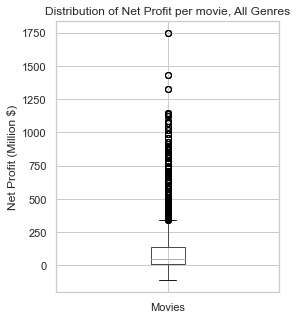

In [30]:
# Create a box and whiskers plot of median profit, 
# to see what the distribution of values looks like
fig, ax = plt.subplots(figsize=(4,5))
millions_df = imdb_tn_split_df[['genres_separated', 'adjusted_worldwide']].copy()
millions_df.adjusted_worldwide = millions_df.adjusted_worldwide / 1000000
millions_df.columns = ['genres_separated', 'Movies']
millions_df\
.boxplot(column='Movies', ax=ax)
ax.set(title='Distribution of Net Profit per movie, All Genres',\
       ylabel='Net Profit (Million $)');


Seems like there are lots of outliers! For our genre graphs we can use the median to mitigate the effect of the outliers.

Lets take a look at a graph of net profit, to see which types of movies create the most profit!

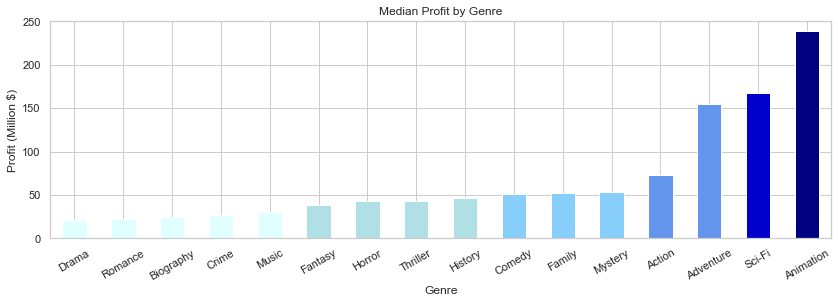

In [31]:
# Graph of how much profit a movie in each genre made, by median value
fig, ax = plt.subplots(figsize=(14,4))
genre_df = genre_df.sort_values('median_adjusted_worldwide')
net_profit = genre_df.median_adjusted_worldwide
net_profit.plot.bar(ax=ax, color=\
     ["lightcyan" if (x < net_profit.quantile(.3)) \
      else 'powderblue' if (x < net_profit.quantile(.6))
      else 'lightskyblue' if (x < net_profit.quantile(.8))
      else 'cornflowerblue' if (x < net_profit.quantile(.9))
      else 'mediumblue' if (x < net_profit.quantile(.95))
      else 'navy' for x in net_profit]);
ax.set(title='Median Profit by Genre', xlabel='Genre', \
       ylabel='Profit (Million $)');
plt.xticks(rotation=30);

Seems like Animation, Sci-Fi, and Adventure made the most profit-wise. However, the Animation genre has a few abnormalities which make it hard to recommend. Animation isn't necessarily a genre itself, it's just a style of movie - every animation movie would have another genre which is its actual genre. Animation studios are also radically different from normal movie studios, and have a high barrier to entry, so it isn't really something we want to recommend for Computing Vision. So it would be best to exclude it from our analysis.

Let's make a graph without Animation!

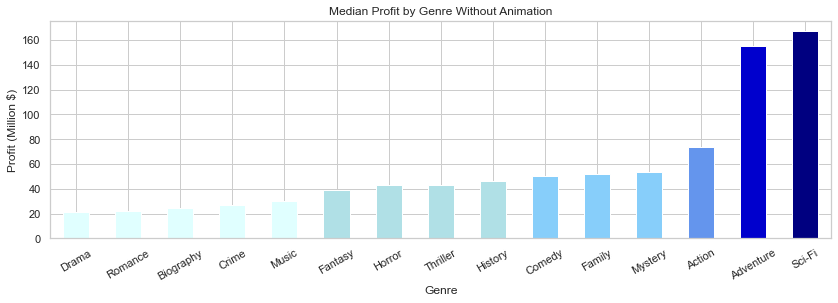

In [32]:
# Graph of how much profit a movie in each genre made, by median value, without 
# animation
fig, ax = plt.subplots(figsize=(14,4))
genre_df = genre_df.sort_values('median_adjusted_worldwide')
net_profit = genre_df[genre_df.index != 'Animation'].median_adjusted_worldwide
net_profit.plot.bar(ax=ax, color=\
     ["lightcyan" if (x < net_profit.quantile(.3)) \
      else 'powderblue' if (x < net_profit.quantile(.6))
      else 'lightskyblue' if (x < net_profit.quantile(.8))
      else 'cornflowerblue' if (x < net_profit.quantile(.9))
      else 'mediumblue' if (x < net_profit.quantile(.95))
      else 'navy' for x in net_profit]);
ax.set(title='Median Profit by Genre Without Animation', xlabel='Genre', \
       ylabel='Profit (Million $)');
plt.xticks(rotation=30);

Alright, that looks more useful! Seems like Sci-Fi and Adventure films are far and away the most profitable! Since we need to make a recommendation to Computing Vision, let's just pick the first one - Sci-Fi. Another benefit of Sci-Fi, which we've found through 3rd party sources, is that Sci-Fi movies are great for merchandise sales, a source of revenue which is not included in our graphs. So Sci-Fi seems like a greate genre to reccomend!

In [33]:
# Get median profit $ of Sci-Fi movies.
genre_df[genre_df.index == 'Sci-Fi'].median_adjusted_worldwide

genres_separated
Sci-Fi    167.054362
Name: median_adjusted_worldwide, dtype: float64

Before we move on, let's look at the profit ratio to make sure this is a good use of our money. While Sci-Fi movies are the most profitable, it is possible that they are inefficient, and it might be better to pick a genre with a higher ratio of profit if that is the case.

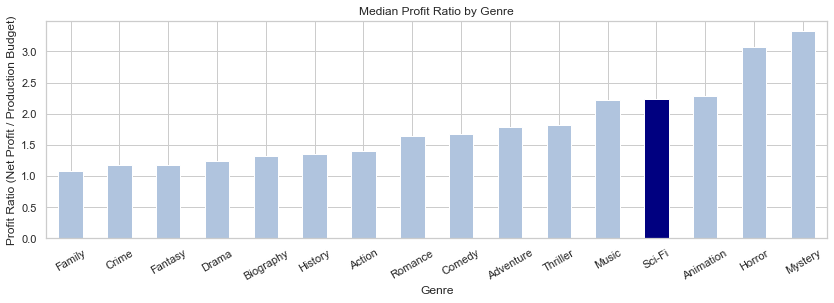

In [34]:
fig, ax = plt.subplots(figsize=(14,4))
genre_df = genre_df.sort_values('median_profit_ratio')
genre_df.median_profit_ratio.plot.bar(ax=ax, color=\
     ["navy" if (x == 'Sci-Fi' ) \
      else 'lightsteelblue' for x in genre_df.index]);
ax.set(title='Median Profit Ratio by Genre', xlabel='Genre', \
       ylabel='Profit Ratio (Net Profit / Production Budget)');
plt.xticks(rotation=30);

Si-Fi is in the top 4, so it seems like the money put into a Sci-Fi movie results in a high profit too! Great! Also notable is that adventure is several spots lower than Sci-Fi on this list, giving us another reason to stick with Sci-Fi.

# Metric 2: Season

Now, Let's take a look at how the season a movie is released in affects how much profit it generates. Let's first take a look at how many movies are in each season using the release_season column we created earlier.

In [35]:
imdb_df_c2["release_season"].value_counts()

fall      335
summer    276
winter    227
spring    213
Name: release_season, dtype: int64

That's a lot of movies in the fall! And a lot less in the spring. Now, let's create a chart, grouping by season, showing the median profit of movies released in each season.

Text(0, 0.5, 'Median Worldwide Profit ($)')

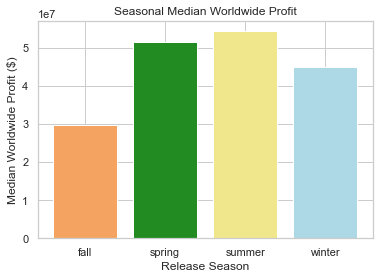

In [36]:
# group rows by release season, and get medians of each
seasonal_medians = imdb_df_c2.groupby("release_season").median()["adjusted_worldwide"]

# create barplot w/ custom colors
fig, ax = plt.subplots()
c = ['sandybrown', 'forestgreen', 'khaki', 'lightblue']
ax.bar(seasonal_medians.index, seasonal_medians, color = c)
ax.set_title("Seasonal Median Worldwide Profit")
ax.set_xlabel("Release Season")
ax.set_ylabel("Median Worldwide Profit ($)")

Looks like spring and summer perform better than winter and fall. Perhaps people prefer watching movies in warmer weather? Let's take a look at the mean too, to see if the data matches up.

Text(0, 0.5, 'Mean Worldwide Profit ($)')

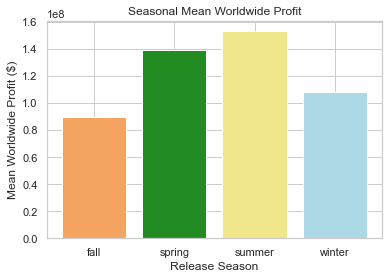

In [37]:
# group rows by release season, and get means of each
seasonal_means = imdb_df_c2.groupby("release_season").mean()["adjusted_worldwide"]

# create barplot w/ custom colors
fig, ax = plt.subplots()
c = ['sandybrown', 'forestgreen', 'khaki', 'lightblue']
ax.bar(seasonal_means.index, seasonal_means, color = c)
ax.set_title("Seasonal Mean Worldwide Profit")
ax.set_xlabel("Release Season")
ax.set_ylabel("Mean Worldwide Profit ($)")

Looks roughly the same, with perhaps even more of a lead for spring and summer! The results look pretty conclusive, but we can run a hypothesis test just to make sure that the results are statistically significant.

H0: Movies that release in warmer seasons do not have larger worldwide profit than those released in colder ones.

Ha: Movies that release in warmer seasons have larger worldwide profit than those released in colder ones.

In [38]:
# only rows where season is fall or winter
cold_season = imdb_df_c2[(imdb_df_c2["release_season"] == "winter") | 
                        (imdb_df_c2["release_season"] == "fall")]

# only rows where season is spring or summer
warm_season = imdb_df_c2.loc[(imdb_df_c2["release_season"] == "summer") | 
                             (imdb_df_c2["release_season"] == "spring")]

In [39]:
results = stats.ttest_ind(warm_season["adjusted_worldwide"], \
                          cold_season["adjusted_worldwide"])
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

The t-statistic is 3.9078710753046453.
The p-value is 9.908052348640371e-05.
We reject the null hypothesis at an alpha level of 0.05.


Looks like we are able to reject the null hypothesis, and confirm that movies released in warmer months perform better! Let's make 1 more graph showing a box and whiskers plot comparing warm and cold months.

Text(0.5, 1.0, 'Worldwide Profit between Cold and Warm Seasons')

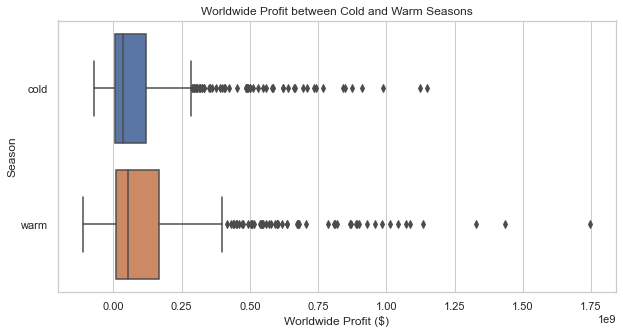

In [40]:
season_list = []
for s in imdb_df_c2["release_season"]:
    if (s == "winter") | (s == "fall"):
        season_list.append("cold")
    else:
        season_list.append("warm")

imdb_df_c2["season_split"] = season_list

fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(x='adjusted_worldwide', y='season_split', data= imdb_df_c2)
ax.set_xlabel("Worldwide Profit ($)")
ax.set_ylabel("Season")
ax.set_title("Worldwide Profit between Cold and Warm Seasons")

The warm distribution overall seems to be distributed to be considerably greater than the cold distribution. Great!

# Metric 3: Runtime

Now, let's see if a movie's runtime affects how it performs in the box office. We can first create a scatter plot with a line of best fit, to see if there is any indication that runtime is correlated with profit.

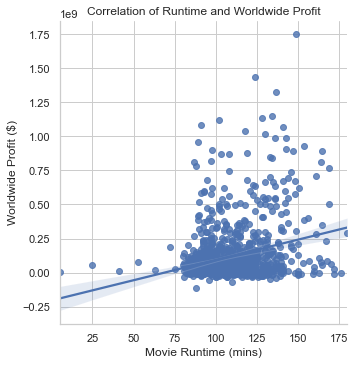

In [41]:
# try drawing a correlation line, visualize correlation
p = sns.lmplot(x ='runtime_minutes', y ='adjusted_worldwide', data = imdb_df_c2)
p.set(title = "Correlation of Runtime and Worldwide Profit")
p.set(xlabel = "Movie Runtime (mins)", ylabel = "Worldwide Profit ($)");

Seems like there is some correlation between runtime and profit. However, it isn't very useful to just recommend making a longer movie. Let's pick a concrete value to be the barrier between a long movie and a short movie, and visualize it using a scatter plot. 120 minutes seems like a nice, round number that serves as a distinction between most 'normal' length movies and long ones.

In [42]:
# divide movies by runtime; movies longer or equal to 2 hours are long movies
long_movies = imdb_df_c2[imdb_df_c2["runtime_minutes"]>= 120]
short_movies = imdb_df_c2[imdb_df_c2["runtime_minutes"]< 120]

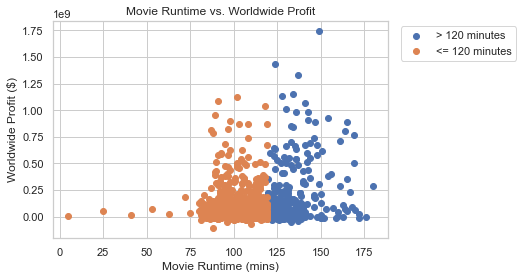

In [43]:
# Display split between long and short movie adjusted worldwide profit
fig, ax = plt.subplots()
sns.set_style('whitegrid')
ax.scatter(long_movies["runtime_minutes"], long_movies["adjusted_worldwide"],\
           label='> 120 minutes')
ax.scatter(short_movies["runtime_minutes"], short_movies["adjusted_worldwide"],\
           label='<= 120 minutes')
ax.set_title("Movie Runtime vs. Worldwide Profit")
ax.set_xlabel("Movie Runtime (mins)")
ax.set_ylabel("Worldwide Profit ($)")
ax.legend(bbox_to_anchor = (1.40, 1));
# fig.show()

It does seem like long movies might perform better, but it is hard to tell just by looking at the graph. Now that we've categorized the data, we can create a histogram to see how the distributions of movies compare, and see if that is more visually compelling. We can also check what the median values for movies in each bucket are, to see if there is a numeric difference.

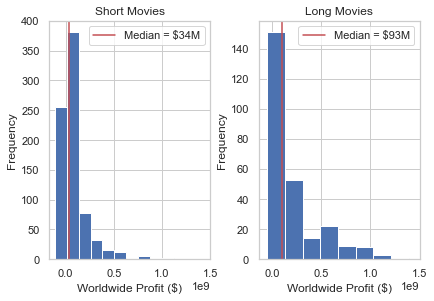

In [44]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout()
ax[1].hist(long_movies["adjusted_worldwide"], bins = 10)
ax[0].hist(short_movies["adjusted_worldwide"], bins = 10)

ax[1].set_title("Long Movies")
ax[1].set_xlabel("Worldwide Profit ($)")
ax[1].set_ylabel("Frequency")
ax[1].set_xlim(right = 1.5 * 10**9)
ax[1].axvline(long_movies["adjusted_worldwide"].median(), color = "r")
ax[1].legend(loc='upper right', labels=['Median = ${}M'\
    .format(int(round(long_movies["adjusted_worldwide"].median()/1000000)))])

ax[0].set_title("Short Movies")
ax[0].set_xlabel("Worldwide Profit ($)")
ax[0].set_ylabel("Frequency")
ax[0].set_xlim(right = 1.5 * 10**9)
ax[0].axvline(short_movies["adjusted_worldwide"].median(), color = "r")
ax[0].legend(loc='upper right', labels=['Median = ${}M'\
    .format(int(round(short_movies["adjusted_worldwide"].median()/1000000)))]);

Wow, the difference between medians is huge! However, it is still difficult to tell that longer movies are performing better - while there is a stronger tail towards the high end of the distribution, it almost seems like there are more long movies around 0 than short movies. Lets perform a statistical test to definitively determine if long movies are more profitable than short movies.


H0: Movies longer than two hours do not make more worldwide profit than those shorter than two hours.

Ha: Movies longer than two hours do make more worldwide profit than those shorter than two hours.

In [45]:
# conduct two-sample t-test (independent)
results = stats.ttest_ind(long_movies["adjusted_worldwide"], 
                          short_movies["adjusted_worldwide"])
alpha = 0.05
print("The t-statistic is {}.".format(results.statistic))
print("The p-value is {}.".format(results.pvalue))
if(results.pvalue < alpha): 
    print("We reject the null hypothesis at an alpha level of {}.".format(alpha))
else:
    print("We fail to reject the null hypothesis at an alpha level of {}.".format(alpha))

The t-statistic is 8.59996881426426.
The p-value is 2.865776372867499e-17.
We reject the null hypothesis at an alpha level of 0.05.


There we have it! We are able to reject the null hypothesis, with a very low p-value! Now we can be confident that movies with runtimes > 120 minutes will perform better in the box office.

# Conclusion

We've determined that the best genre to use is Sci-Fi, the best time to release our movie is in the Spring or Summer, and our movie should be over 120 minutes long. Let's put our proposed characteristics to the test, and check how movies which match our recommendation performed in the real world.

### Visualize the Ideal Movie

In [46]:
movie_samp = imdb_df_c2.loc[(imdb_df_c2["runtime_minutes"] >= 120) &
                           (imdb_df_c2["season_split"] == "warm") & 
                           [("Sci-Fi" in g) for g in imdb_df_c2["genres_list"]]]
movie_samp[["primary_title", "runtime_minutes", "season_split", "genres_list", 
            "adjusted_worldwide"]].sample(n=5, random_state=77777)

,primary_title,runtime_minutes,season_split,genres_list,adjusted_worldwide
316,The Wolverine,126.0,warm,"[Action, Adventure, Sci-Fi]",301456852
331,Prometheus,124.0,warm,"[Adventure, Mystery, Sci-Fi]",277448265
2,Jurassic World,124.0,warm,"[Action, Adventure, Sci-Fi]",1433854864
215,X-Men: First Class,131.0,warm,"[Action, Adventure, Sci-Fi]",195408305
576,The Amazing Spider-Man 2,142.0,warm,"[Action, Adventure, Sci-Fi]",508996336


Wow, those are some big movies! This does reveal some problems with our genre testing, in that it was difficult to separate closely related genres such as Action, Adventure, and Sci-Fi seen in the chart above. In fact if we count the values...

In [47]:
movie_samp.genres.value_counts()

Action,Adventure,Sci-Fi     31
Horror,Sci-Fi,Thriller       1
Adventure,Mystery,Sci-Fi     1
Name: genres, dtype: int64

...we can see that 31/33 of our matching movies have the same 3 genres. Not ideal! However, these movies ARE all Sci-Fi, and Sci-Fi movies were ahead of the other genres on our chart, so we can still be confident in our reccomendation.

Let's create a few graphs using our selected movies, and then look at the how the average 'ideal' movie performs.

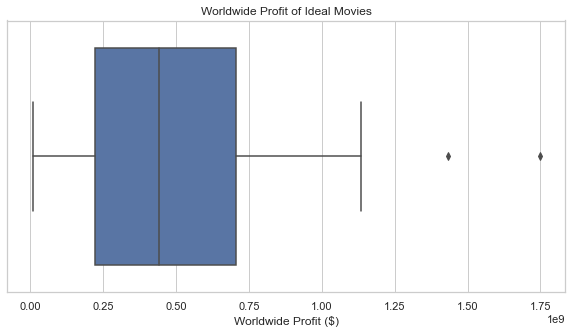

In [48]:
fig, ax = plt.subplots(figsize = (10,5))
sns.boxplot(x='adjusted_worldwide', data= movie_samp)
ax.set_xlabel("Worldwide Profit ($)")
ax.set_title("Worldwide Profit of Ideal Movies");

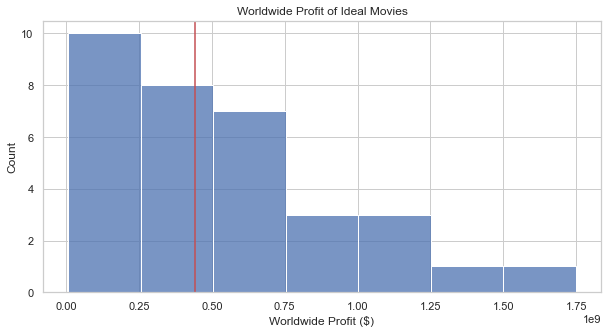

In [49]:
fig, ax = plt.subplots(figsize = (10,5))
sns.histplot(x='adjusted_worldwide', data= movie_samp)
ax.set_xlabel("Worldwide Profit ($)")
ax.set_title("Worldwide Profit of Ideal Movies")
plt.axvline(movie_samp["adjusted_worldwide"].median(), color = "r");

In [50]:
# mean Profit
round(movie_samp["adjusted_worldwide"].mean(),2)

539822447.24

In [51]:
# median Profit
round(movie_samp["adjusted_worldwide"].median(),2)

442999518.0

In [52]:
# IQR of Profit
round(movie_samp["adjusted_worldwide"].quantile(.75),2) \
        - round(movie_samp["adjusted_worldwide"].quantile(.25),2)

484163444.0

In [53]:
# Median of all movies in the dataset
imdb_df_c2["adjusted_worldwide"].median()

42797409.0

In [54]:
# 10x Higher
movie_samp["adjusted_worldwide"].median() / imdb_df_c2["adjusted_worldwide"].median()

10.351082655494402

With a median profit of $442 million, our selected movies are over 10 times more profitable on average than the movies in the full dataset. Awesome!

In [55]:
# Remember to close the connection.
conn.close()